![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [5]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [6]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot:title={'center':'Sentiminetos por aerolínea'}, xlabel='airline'>

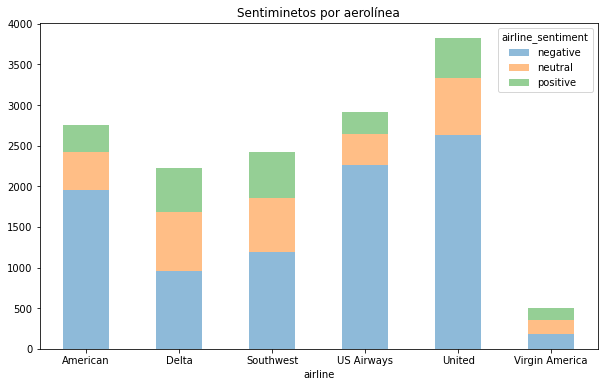

In [7]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud,ImageColorGenerator
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maste\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maste\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maste\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\maste\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maste\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [11]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [12]:
# Celda 1
# antes de iniciar es importante realizar una limpieza del corpus, buscando eliminar numeros, signos etc. 

def cleanText(text):
    text = text.lower()
    text = re.sub('[^A-Za-z\']',' ',text)
    text = re.sub('\s*\\b([a-z]|[a-z]{2})\\b','', text).strip()
    text = " ".join(text.split())
    return text 

X_train = X_train.apply(cleanText)

# dado que el punto no prohibe el uso de n_grams se usarán bigramas
vect_1 = CountVectorizer(dtype=np.int8)
X_dtm_A = vect_1.fit_transform(X_train)


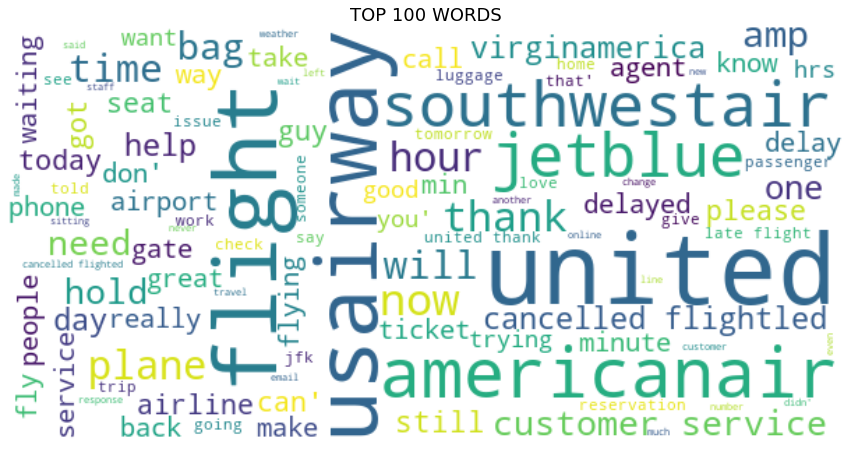

In [13]:
# otra buena práctica es realizar la impresión de un wordcloud, en este caso se puede observar que el nombre de la aerolinea es 
# dominante
long_t = (" ").join(text for text in X_train)
wordcloud = WordCloud(max_font_size=70, max_words=100,background_color="white", width=600, height=300).generate(long_t)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("TOP 100 WORDS", fontsize=18)
plt.show()

In [14]:
# se realizo el ejercicio de retirar los nombre de la aerolinea de las stop words,
# pero el resultado no fue óptimo


RFC = RandomForestClassifier(random_state=0, n_jobs=-1)
RFC.fit(X_dtm_A,y_train)
X_test = X_test.apply(cleanText)
X_dtm_A_test = vect_1.transform(X_test)

pred = RFC.predict(X_dtm_A_test)
target_names = ["Positive","Negative","Neutral"]
print(metrics.classification_report(y_true=y_test,y_pred=pred, labels=y_test.unique(), target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.82      0.52      0.64       763
    Negative       0.80      0.94      0.86      3085
     Neutral       0.65      0.45      0.53       984

    accuracy                           0.78      4832
   macro avg       0.76      0.64      0.68      4832
weighted avg       0.77      0.78      0.76      4832



In [15]:
# ya que para el caso de multicalsifación el accuracy corresponde al recall reportado con el metodo classification
# report, no se utlizara más el cálculo siguiente
cm = metrics.confusion_matrix(y_true=y_test, y_pred=pred, labels=[1,0,-1])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()


array([0.51900393, 0.45325203, 0.94489465])

### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [16]:
# Celda 2
recover = ['ain','aren',"aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't",
 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't",
 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won',
 "won't", 'wouldn', "wouldn't"]
stwords = [x for x in stopwords.words("english") if x not in recover]


In [17]:
# Xtrain y X_test ya tienen el proceso de limpieza aplicado en los pasos anteriores
vect_2 = CountVectorizer(stop_words=stopwords.words("english"), dtype=np.int8)
X_dtm_B = vect_2.fit_transform(X_train)
RFC.fit(X_dtm_B,y_train)
X_dtm_B_test = vect_2.transform(X_test)

pred = RFC.predict(X_dtm_B_test)
target_names = ["Positive","Negative","Neutral"]
print(metrics.classification_report(y_true=y_test,y_pred=pred, labels=y_test.unique(), target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.75      0.58      0.66       763
    Negative       0.81      0.90      0.86      3085
     Neutral       0.59      0.48      0.53       984

    accuracy                           0.77      4832
   macro avg       0.72      0.66      0.68      4832
weighted avg       0.76      0.77      0.76      4832



### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [18]:
# Celda 3
# con el objetivo de identificar correctamente las palbras a lematizar, se debe declarar correctamente
# el part of specch tag POS tag como segundo argumento de lematize
# en este sentido se solicita usar solamente verbos al lematizar, esto presenta el inconveniente
# que una misma palabra puede tener dos o más lemas, por lo que se debe asignar el POS tag correcto
# construyendose una función para agregarla como segundo argumento de la función Lematizer.lemmatize()



def lematizacion(text):

    def get_words_post_tag(word):
    
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    Lematizer = WordNetLemmatizer()
    text = nltk.word_tokenize(text)
    text = (" ").join(Lematizer.lemmatize(word, get_words_post_tag(word)) for word in text)
    
    return text 

X_train_lema = X_train.apply(lematizacion)

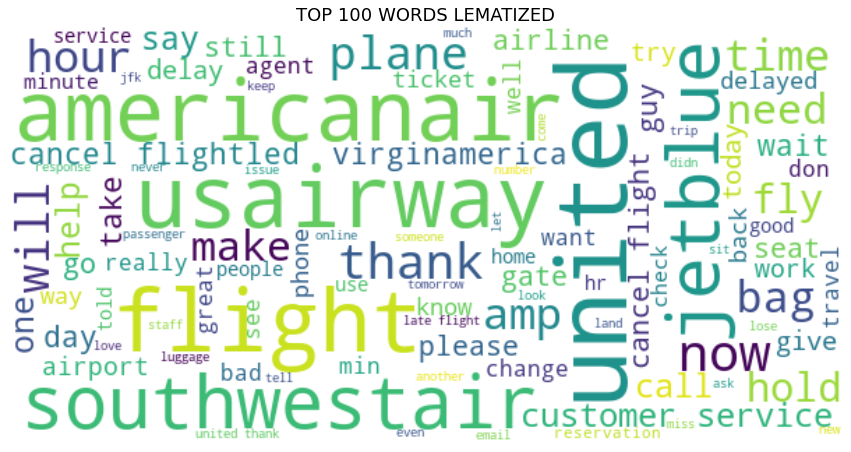

In [19]:
long_t = (" ").join(text for text in X_train_lema)
wordcloud = WordCloud(max_font_size=70, max_words=100,background_color="white", width=600, height=300).generate(long_t)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("TOP 100 WORDS LEMATIZED", fontsize=18)
plt.show()

In [20]:
# en esta ocasion podemos reutilizar vect_1
X_dtm_L = vect_1.fit_transform(X_train_lema)
RFC.fit(X_dtm_L,y_train)
X_test_lema = X_test.apply(lematizacion)
X_dtm_L_test = vect_1.transform(X_test_lema)

pred = RFC.predict(X_dtm_L_test)
target_names = ["Positive","Negative","Neutral"]
print(metrics.classification_report(y_true=y_test,y_pred=pred, labels=y_test.unique(), target_names=target_names))
print(metrics.accuracy_score(y_pred=pred,y_true=y_test, normalize=False))

              precision    recall  f1-score   support

    Positive       0.84      0.52      0.64       763
    Negative       0.80      0.95      0.86      3085
     Neutral       0.66      0.46      0.54       984

    accuracy                           0.78      4832
   macro avg       0.76      0.64      0.68      4832
weighted avg       0.77      0.78      0.76      4832

3771


### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [21]:
# Celda 4
# para este ejemplo podemos utilizar vect_2 nuevamente y referirise a los conjuntos lematizados
# previamente creados

X_dtm_all = vect_2.fit_transform(X_train_lema)
RFC.fit(X_dtm_all,y_train)
X_dtm_all_test = vect_2.transform(X_test_lema)

pred = RFC.predict(X_dtm_all_test)
target_names = ["Positive","Negative","Neutral"]
print(metrics.classification_report(y_true=y_test,y_pred=pred, labels=y_test.unique(), target_names=target_names))
print(metrics.accuracy_score(y_pred=pred,y_true=y_test, normalize=False))


              precision    recall  f1-score   support

    Positive       0.76      0.58      0.66       763
    Negative       0.81      0.91      0.86      3085
     Neutral       0.60      0.49      0.54       984

    accuracy                           0.77      4832
   macro avg       0.72      0.66      0.69      4832
weighted avg       0.76      0.77      0.76      4832

3725


### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

Text(0, 0.5, 'Global accuracy')

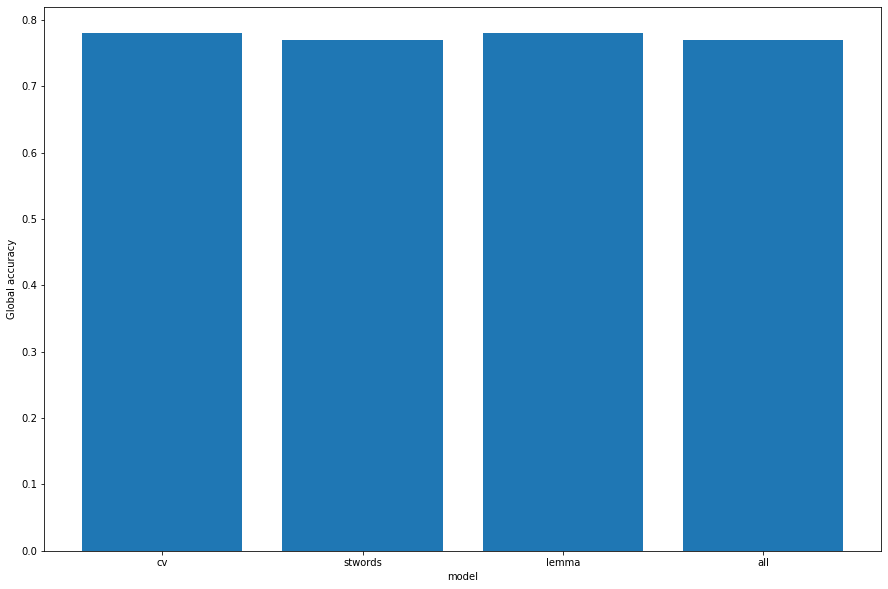

In [25]:
model = ["cv","stwords","lemma","all"]
g_accuraccy = [0.78,0.77,0.78,0.77]
plt.figure(figsize=(15,10))
plt.bar(x=model, height=g_accuraccy)
plt.xlabel("model")
plt.ylabel("Global accuracy")


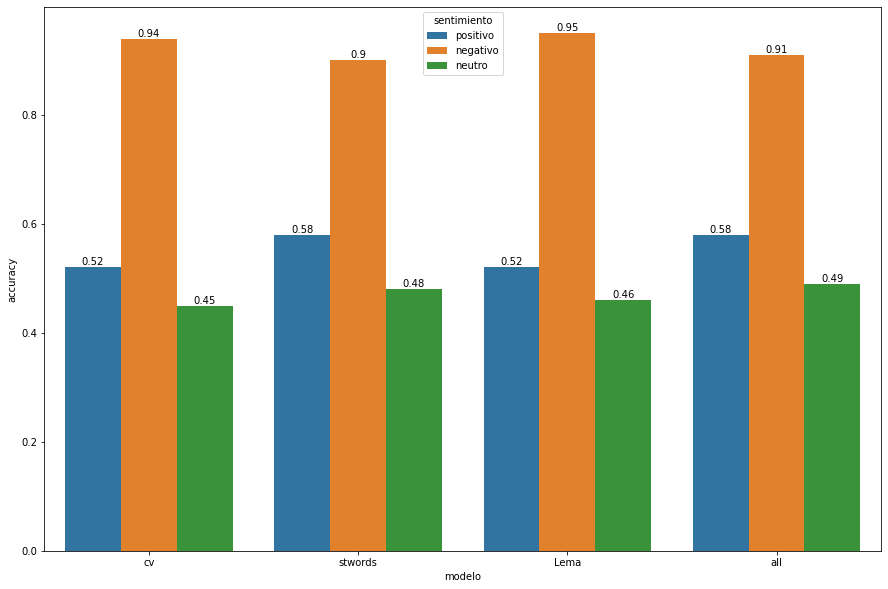

In [22]:
# Celda 5
# df_accur = pd.DataFrame([[0.52,0.94,0.45],[0.58,0.90,0.48],[0.52,0.95,0.46],[0.58,0.91,0.49]],
#  columns=["positivo","negativo","neutral"], index=["cv","stwords","Lema","all"])

d = [["positivo",0.52,"cv"],
     ["negativo",0.94,"cv"],
     ["neutro",0.45,"cv"],
     ["positivo",0.58,"stwords"],
     ["negativo",0.90,"stwords"],
     ["neutro",0.48,"stwords"],
     ["positivo",0.52,"Lema"],
     ["negativo",0.95,"Lema"],
     ["neutro",0.46,"Lema"],
     ["positivo",0.58,"all"],
     ["negativo",0.91,"all"],
     ["neutro",0.49,"all"]]
df_accur = pd.DataFrame(d, columns=["sentimiento","accuracy","modelo"])
plt.figure(figsize=(15,10))
ax = sns.barplot(x="modelo",y="accuracy",data=df_accur, hue="sentimiento")
for container in ax.containers:
    ax.bar_label(container)

Dado a lo anterior, se puede observar un comportamiento del accuracy global del modelo multiclasificación bastante similar, pero dado a que las clases presentan desbalanceo, resulta conveniente revisar el accuracy de cada clase. En este sentido, si dentro del objetivo de negocio se puede sacrificar algo de accuracy para la clase negativa, el mejor resultado estaría compuesto por el modelo calculado con countvectorizer-stopwords-lematización, ahora bien, si lo que se prefiere es predecir el sentimiento negativo, el modelo lematizado ofrece el mejor rendimiento de todos. Cabe resaltar que los resultados no son especialmentediferentes entre métodos, salvo por el sentimiento positivo, que presenta un cambio de 0.06 entre countvectorizer solo y los demás metodos.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d7aae180-d057-4a29-8f6e-71514217df84' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>